### Preprocessing: Text-processing, For-loop, API Requests.

### 1. Import Modules

* `numpy`: provides support for large, multi-dimensional arrays and matrices, as well as a collection of mathematical functions to operate on these arrays. 
* `pandas`: a powerful and easy-to-use library for data manipulation and analysis. It provides data structures for efficiently storing and querying large datasets, as well as functions for cleaning, transforming, and merging data. 
* `datetime`: provides classes for working with dates and times, including date arithmetic, formatting, and parsing. 
* `warnings`: provides a way to ignore warning messages in Python code. 
**API:
First, we need to import `Journals` from `crossref.restful` module to fetch publication information by ISSN from Crossref. Then, we initialize an instance of Journals class to fetch publication metadata using ISSN We also need to import `json` and `urlopen` modules from `urllib.request` module to fetch publication information by ISBN from Googlebooks.

In [1]:
# import basic modules

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

#import seaborn as sns

from datetime import datetime
#from time import sleep
#from pandas.tseries.offsets import MonthEnd

import warnings
warnings.filterwarnings('ignore')
#import multiprocessing

In [2]:
# import Crossref journals module
from crossref.restful import Journals
import json
from urllib.request import urlopen

### 2. Import a File

The following code reads in an EXCEL file and selects specific columns to work with. It then filters the resulting DataFrame to only include `Article` requests and prints out some summary information about the DataFrame.

In [3]:
# Specify the name of the EXCEL file to read in

# Prompt user to input their multipass id
multipass_id = input("Enter your multipass ID: ")

input_name = input("Enter ILLiad Monthly File Name: `Do not enter .xlsx part`" )
input_file_name = input_name+".xlsx"

input_file_path = (f"C:\\Users\\{multipass_id}\\Box\\\Annual Report Procedures\\ILLiad Statistics\\ill_titles_data\\{input_file_name}")

# Read in the EXCEL file and select the columns we need
ill_df = pd.read_excel(input_file_path, usecols=["Transaction Number", "Request Type", "Process Type", "Photo Journal Title", "Photo Journal Year", "ISSN", "Creation Date", "Status", "Transaction Status", "Reason For Cancellation", "Document Type", "Department"])

# Filter for only Article requests
filter = ill_df["Request Type"].isin(["Article"])
article = ill_df[filter]

In [4]:
article.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 1 to 1004
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Transaction Number       754 non-null    int64         
 1   Request Type             754 non-null    object        
 2   Photo Journal Title      743 non-null    object        
 3   Photo Journal Year       748 non-null    object        
 4   Transaction Status       754 non-null    object        
 5   ISSN                     735 non-null    object        
 6   Reason For Cancellation  141 non-null    object        
 7   Process Type             754 non-null    object        
 8   Document Type            697 non-null    object        
 9   Creation Date            754 non-null    datetime64[ns]
 10  Status                   754 non-null    object        
 11  Department               754 non-null    object        
dtypes: datetime64[ns](1), int64(1), obj

### 3. Auto-Look up

#### 3-1. Set up a New DataFrame
We start by creating a Pandas DataFrame to store the information we'll retrieve. The DataFrame has columns for the `transaction number`, `issn`, `title`, and the `original` ISSN or ISBN that was used to search for the article.

We then loop through each transaction number in the list of borrowing transactions, and add it to the DataFrame.

#### 3-2 String Manipulation 
For each transaction number and corresponding ISSN in our lists, we first clean the ISSN string to remove any hyphens or spaces. Then, we check the length of the cleaned string to determine whether it's an 8-digit or 13- or 10-digit ISSN.

#### 3-3 Extract Data from Crossref and Googlebooks
If the cleaned string is 8 digits, we add a hyphen in the appropriate place to make it a valid ISSN. Then, we use the Crossref module to check whether the journal with that ISSN exists. If it does, we extract the first ISSN in the list of ISSNs (sometimes journals have multiple ISSNs), and we use this ISSN to look up the title of the journal in the Crossref database.

If the cleaned string is 13 or 10 digits, we assume it's an ISBN (International Standard Book Number) and we use the Googlebooks module to look up the title of the book. We extract the first identifier in the list of industry identifiers (sometimes books have multiple ISBNs), and we use this identifier as the ISSN for our dataframe.

#### 3-4 Store data in a DataFrame
We then repeat this process for all the transaction numbers and ISSNs in our lists, and we store the results in our dataframe.

Finally, we have a DataFrame that contains the transaction number, ISSN, and title of each article.

In [5]:
# article data
# Initialize Crossref and Google Books API
journals = Journals()
api = "https://www.googleapis.com/books/v1/volumes?q=isbn:"

# Extract relevant columns from dataframe
issn_list = list(article["ISSN"])
transaction_list = list(article['Transaction Number'])

# Initialize new dataframe
new_df = pd.DataFrame(columns=['Transaction Number', 'issn', 'title', 'original'])

# Iterate through the transaction list and search for corresponding ISSNs and titles
for idx, v in enumerate(transaction_list):
    new_df.loc[idx, 'Transaction Number'] = v

for idx, x in enumerate(issn_list):
    x = str(x)
    new_df.loc[idx, 'original'] = x
    x_short = x.replace("-", '').replace(" ", '').strip()
    
    if len(x_short) == 8:
        x_issn = x_short[0:4] + "-" + x_short[4:8]
        if journals.journal_exists(x_issn):
            try:
                n_issn = journals.journal([x_issn])['ISSN'][0]
                new_df.loc[idx, 'issn'] = n_issn
                new_df.loc[idx, 'title'] = journals.journal([n_issn])['title']
            except:
                pass
    elif len(x_short) == 13 or len(x_short) == 10:
        try:
            resp = urlopen(api + x_short)
            book_data = json.load(resp)
            volume_info = book_data["items"][0]["volumeInfo"]
            new_df.loc[idx, 'issn'] = volume_info['industryIdentifiers'][0]['identifier']
            new_df.loc[idx, 'title'] = volume_info['title']
        except:
            pass

In [6]:
print("New DataFrame Preview:")
new_df

New DataFrame Preview:


,Transaction Number,issn,title,original
0,456055,NaN,NaN,1075-7732
1,455945,NaN,NaN,1532-0979
2,455954,0366-7022,Chemistry Letters,0366-7022
3,455973,1465-9891,Journal of Substance Use,1465-9891
4,455972,0734-7324,Alcoholism Treatment Quarterly,0734-7324
...,...,...,...,...
749,456755,1060-3743,Journal of Second Language Writing,1060-3743
750,456775,0305-4179,Burns,0305-4179
751,456370,NaN,NaN,0003-9780
752,456761,0085-4530,Der Orthopäde,0085-4530


### 4.  Check Outputs
This code creates the new dataframes directly from `new_df` and uses `downcast='integer'` when converting the Transaction Number column to numeric. It also uses `info()` to print out the information.

In [7]:
# Borrowing data Lookup Output

issn_title_lookup = pd.DataFrame(new_df, columns=['Transaction Number', 'issn', 'title'])
issn_title_lookup['Transaction Number'] = pd.to_numeric(issn_title_lookup['Transaction Number'], downcast='integer')
issn_title_lookup.columns = ['Transaction Number', 'issn', 'title']
print(f"issn_title_lookup info")
print('---------------------------------------------------------------')
issn_title_lookup.info()

print('===============================================================')


issn_title_lookup info
---------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 0 to 753
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Transaction Number  754 non-null    int32 
 1   issn                575 non-null    object
 2   title               575 non-null    object
dtypes: int32(1), object(2)
memory usage: 36.8+ KB


### 5. Update Data
This code defines a function that merges the data and replaces the columns.

In [8]:
# Define a function to merge data and replace columns
def merge_data(df, lookup_df):
    # Merge data with issn_title_lookup data
    df_with_metadata = pd.merge(df, lookup_df[['Transaction Number', 'issn', 'title']], how='left', on='Transaction Number')

    # Replace the "ISSN" column in df with the corresponding values from issn_title_lookup where available
    df_with_metadata.loc[lookup_df['issn'].notnull(), 'ISSN'] = lookup_df.loc[lookup_df['issn'].notnull(), 'issn']

    # Replace the "Photo Journal Title" column in df with the corresponding values from issn_title_lookup where available
    df_with_metadata.loc[lookup_df['title'].notnull(), 'Photo Journal Title'] = lookup_df.loc[lookup_df['title'].notnull(), 'title']

    # Convert "Creation Date" to datetime and extract "year"
    df_with_metadata['Creation Date'] = pd.to_datetime(df_with_metadata['Creation Date']).dt.strftime('%Y-%m-%d')
    df_with_metadata['year'] = pd.DatetimeIndex(df_with_metadata['Creation Date']).year

    # Drop the 'issn' and 'TITLE' columns
    df_with_metadata.drop(['issn', 'title'], axis=1, inplace=True)
    
    return df_with_metadata

# Merge borrowing data with issn_title_lookup data
article_with_publication_metadata = merge_data(article, issn_title_lookup)



In [9]:
article_with_publication_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 0 to 753
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Transaction Number       754 non-null    int64 
 1   Request Type             754 non-null    object
 2   Photo Journal Title      743 non-null    object
 3   Photo Journal Year       748 non-null    object
 4   Transaction Status       754 non-null    object
 5   ISSN                     735 non-null    object
 6   Reason For Cancellation  141 non-null    object
 7   Process Type             754 non-null    object
 8   Document Type            697 non-null    object
 9   Creation Date            754 non-null    object
 10  Status                   754 non-null    object
 11  Department               754 non-null    object
 12  year                     754 non-null    int64 
dtypes: int64(2), object(11)
memory usage: 82.5+ KB


### 6. Impact

By leveraging API data from Crossref and Google Books, we were able to significantly improve the accuracy of our data-driven decision making process. Our initial dataset contained a total of ### inputs, with ### unique titles that had been manually entered by patrons. However, due to variations in capitalization, punctuation, and spacing, the format of the titles was not consistent, which made it difficult to analyze the data effectively.

Through our search using API data, we were able to standardize the formatting of the titles and correct any discrepancies in ISSN or ISBN numbers. We replaced the "ISSN" and "Photo Journal Title" columns (from borrowing data) with new information (from issn_title_lookup data), but only when the issn_title_lookup had non-null data for these columns. In cases where the issn_title_lookup did not have data for these columns, we kept the original data from borrowing to avoid data loss.

As a result of this process, the number of unique titles increased to ### out of a total of ### inputs, with the data loss minimized due to the replacement of standardized ISSN and title information with patron-entered data. This represents a significant improvement in the accuracy and reliability of our data.

Although some journals were not available through the Crossref or Google Books database, we believe that it was still important to validate and standardize the data that we did have in order to ensure that our data-driven decision making process was as accurate and effective as possible.

743
587


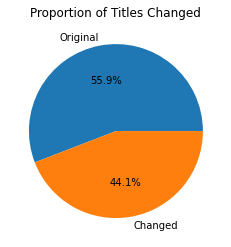

In [10]:
# Proportion of Titles Changed
import matplotlib.pyplot as plt
# Define the data before and after standardization
total = article['Photo Journal Title'].count()

before_set = set(article['Photo Journal Title'])
after_set = set(article_with_publication_metadata['Photo Journal Title'])
counter = 0 #initialize counter
for b, a in zip(before_set, after_set):
    if b != a:
        counter +=1
num_changes = counter    

values = [total, num_changes]
labels = ['Original', 'Changed']
print(total)
print(num_changes)

plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Titles Changed')
plt.show()

### 7. Save 

This code block saves the final results of our analysis to an Excel file. First, it creates a pd.ExcelWriter object called datatoexcel with the specified file path, which is where we want to save the data. Next, it uses the to_excel function to write the contents of the borrowing(/ lending)_with_publication_metadata DataFrame to the datatoexcel Excel file. We pass index=False to exclude the DataFrame index from being written to the file and encoding='utf-8-sig' to ensure that non-ASCII characters are properly encoded. Finally, we call datatoexcel.save() to save the file to disk.

By running this code, we can export our data in a format that can be easily shared with others or imported into other programs for further analysis.

In [11]:
# Filter for Borrowing and Lending requests
borrowing = article_with_publication_metadata[article_with_publication_metadata["Process Type"].isin(["Borrowing"])]
lending = article_with_publication_metadata[article_with_publication_metadata["Process Type"].isin(["Lending"])]

# Print out summary info for the borrowing and lending DataFrames
borrowing.info()
lending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 0 to 753
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Transaction Number       408 non-null    int64 
 1   Request Type             408 non-null    object
 2   Photo Journal Title      397 non-null    object
 3   Photo Journal Year       405 non-null    object
 4   Transaction Status       408 non-null    object
 5   ISSN                     397 non-null    object
 6   Reason For Cancellation  16 non-null     object
 7   Process Type             408 non-null    object
 8   Document Type            408 non-null    object
 9   Creation Date            408 non-null    object
 10  Status                   408 non-null    object
 11  Department               408 non-null    object
 12  year                     408 non-null    int64 
dtypes: int64(2), object(11)
memory usage: 44.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index

In [12]:
# Prompt user to input their multipass id
multipass_id = input("Enter your multipass ID: ")

# Define the file names and dataframes

file_names = []
borrowing.name = 'borrowing'
lending.name = 'lending'
data_frames = [borrowing, lending]

#Loop through the data frames and ask for the file name

for data_frame in data_frames:
    save_name=  input(f"Enter the file name for {data_frame.name}: Follow the naming convention `borrowing_YYYY_mm_dd.xlsx` or `lending_YYYY_mm_dd.xlsx`")
    file_names.append(save_name)

# Loop through the file names and data frames

for file_name, data_frame in zip(file_names, data_frames):
    # Create the Excel writer
    datatoexcel = pd.ExcelWriter(f"C:\\Users\\{multipass_id}\\Box\\Annual Report Procedures\\ILLiad Statistics\\ill_titles_powerbi\\{file_name}")

    # Write the data frame to the Excel file
    data_frame.to_excel(datatoexcel, index=False, encoding='utf-8-sig')
    # Save the Excel file
    datatoexcel.save()
    
print("Saved")

Saved
